## Fitness Tracker Analysis - Part 2

**Continued from Part 1 here:**

`/notebooks/nk-fitness-tracker-p1-exploratory.ipynb`

Github link: https://github.com/nkeblawi/nk-fitness-tracker/blob/main/notebooks/nk-fitness-tracker-p1-exploratory.ipynb

### 2.1 - Detecting Outliers in Sensor Data

The next step is to check whether there are extreme values or outliers in the data that should be removed before modeling.

Load the necessary libraries:

In [16]:
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import src.features.remove_outliers as remove_outliers
import src.visualization.visualize as vis

Set the plotting style:

In [17]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100

Load the preprocessed dataset into pandas DataFrame:

In [18]:
df = pd.read_pickle("data/interim/01_data_processed.pkl")

### 2.2 - Using Box Plots

array([<Axes: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_z'}, xlabel='[label]'>], dtype=object)

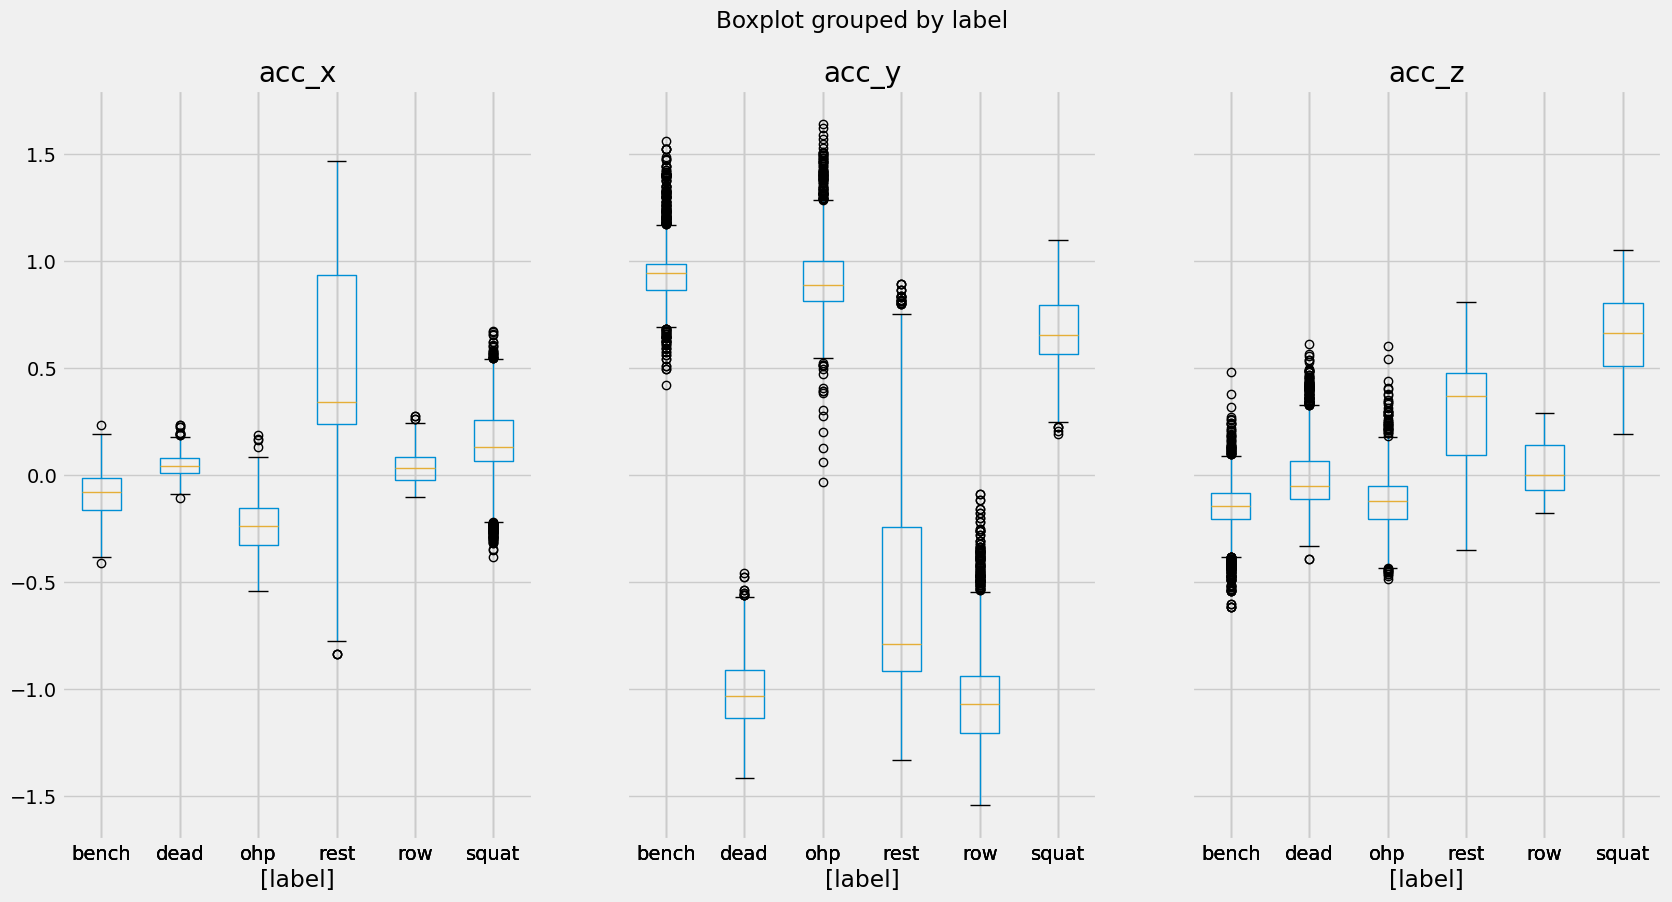

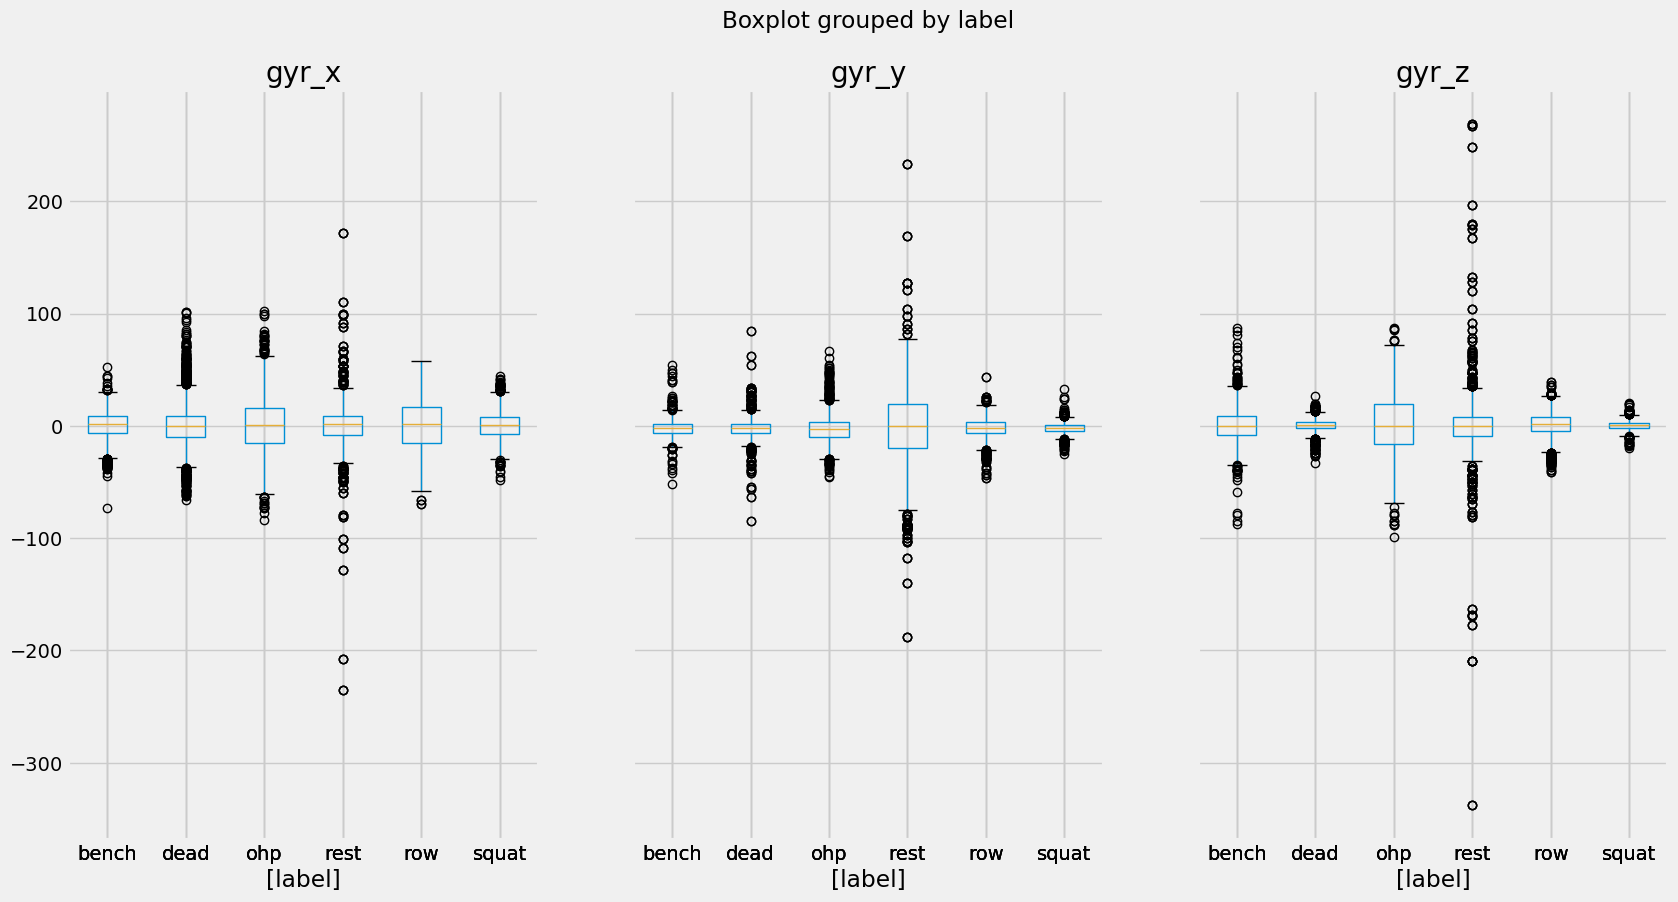

In [19]:
# Use box plots to see the extent of outliers in each type of exercise
outlier_columns = list(df.columns[:6])

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

Plotting outliers in each set shows a lot of extreme values, but we can't just remove them all using a brute force strategy. We need to visualize them in other ways to see if there's a pattern among these outliers. This way, we can make an informed choice using the outlier detection functions below.

### 2.3 - Define Binary Outlier Methods

Use Mark Hoogendoorn's function to plot binary outlier scores. Source code can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.

Defined this function in the `remove_outliers` script as `plot_binary_outliers()`

#### 2.3.1 - Inquartile Ranges Method for Outlier Detection

When using a boxplot, the box extends from Q1 to Q3 quartile values of the data, when a line across the median (Q2). The whiskers extend from the edges of the box to show the full range of data, including outliers. By default, they extend no more than 1.5 * IQR, where IQR = Q3 - Q1, from the edges of the box. Any data points beyond the whiskers are considered outliers.

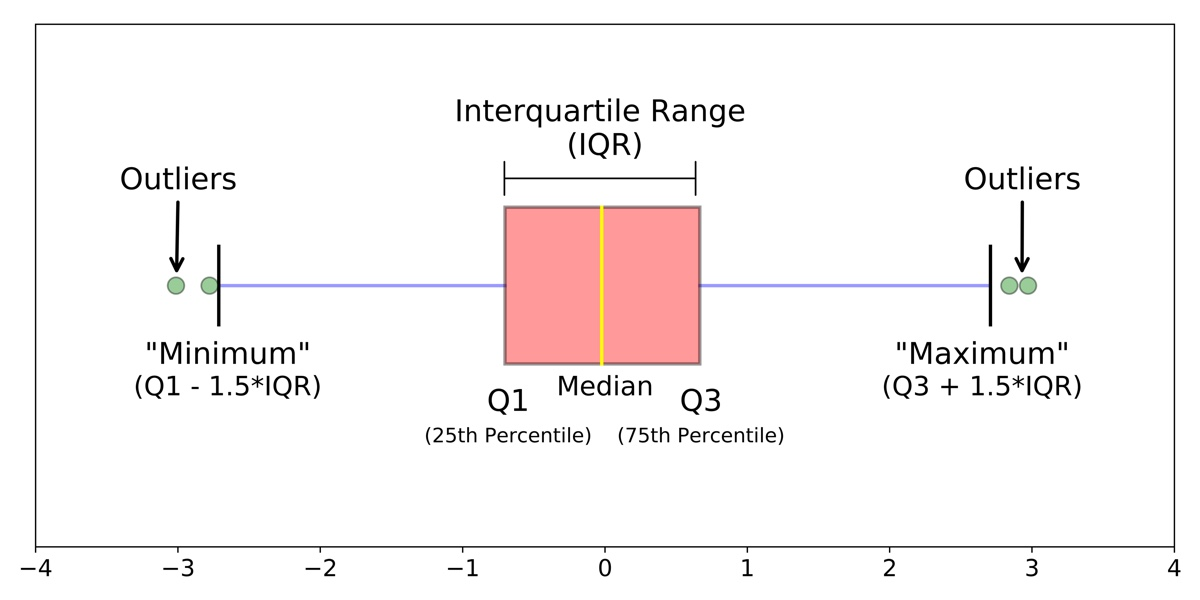

Image from: https://www.linkedin.com/in/michaelgalarnyk/

Defined this function in the `remove_outliers` script as  `mark_outliers_iqr()`

#### 2.3.2 - Plotting Outliers Using the Boxplot and IQR Method

Test this method and mark outliers as red, normal data points as blue.

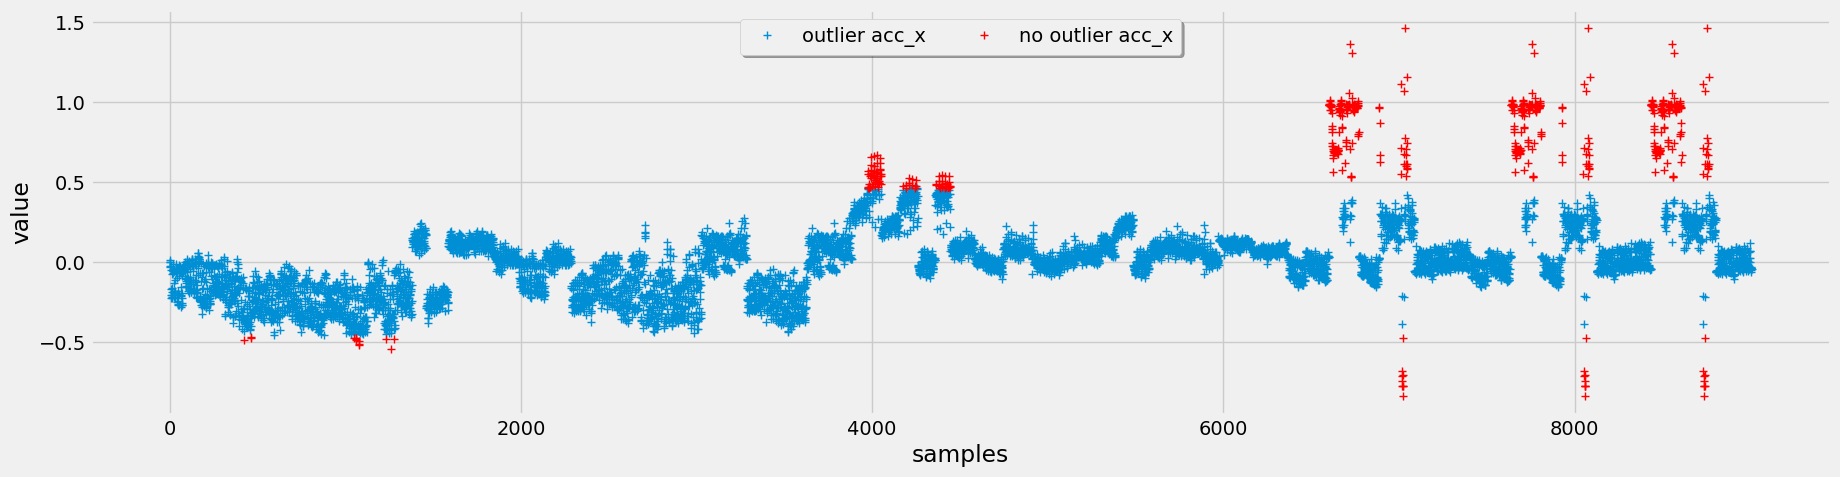

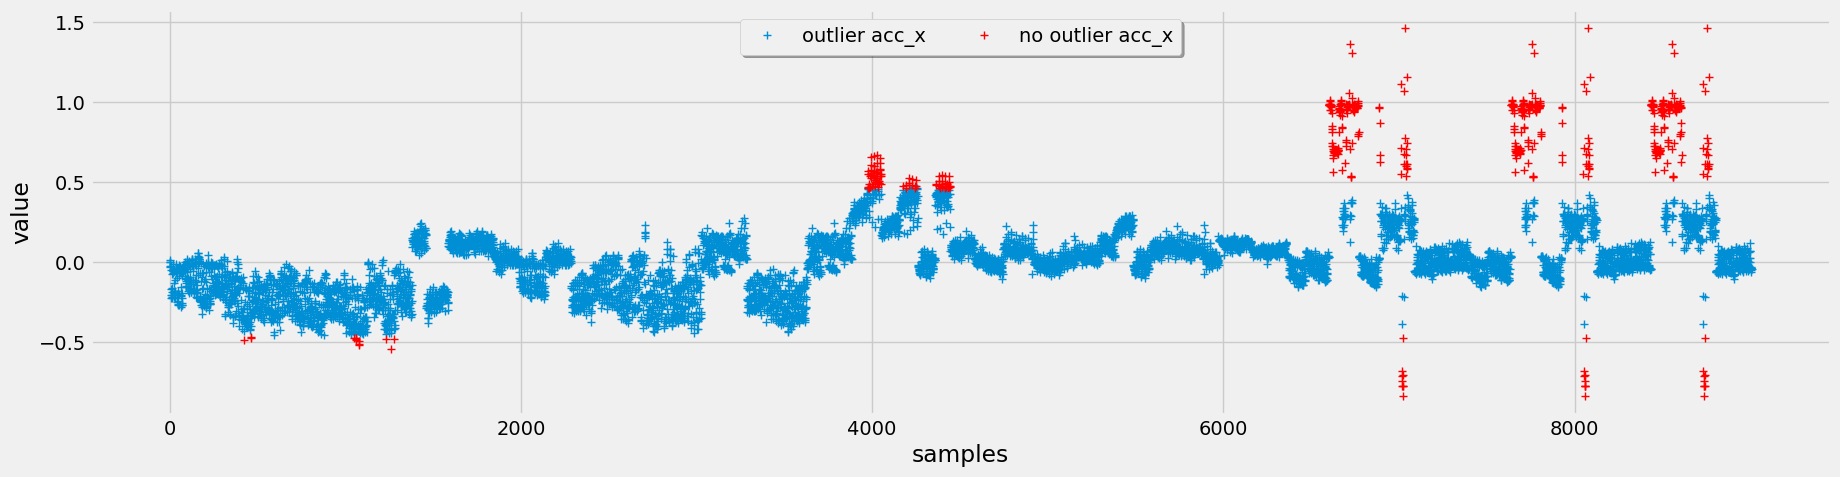

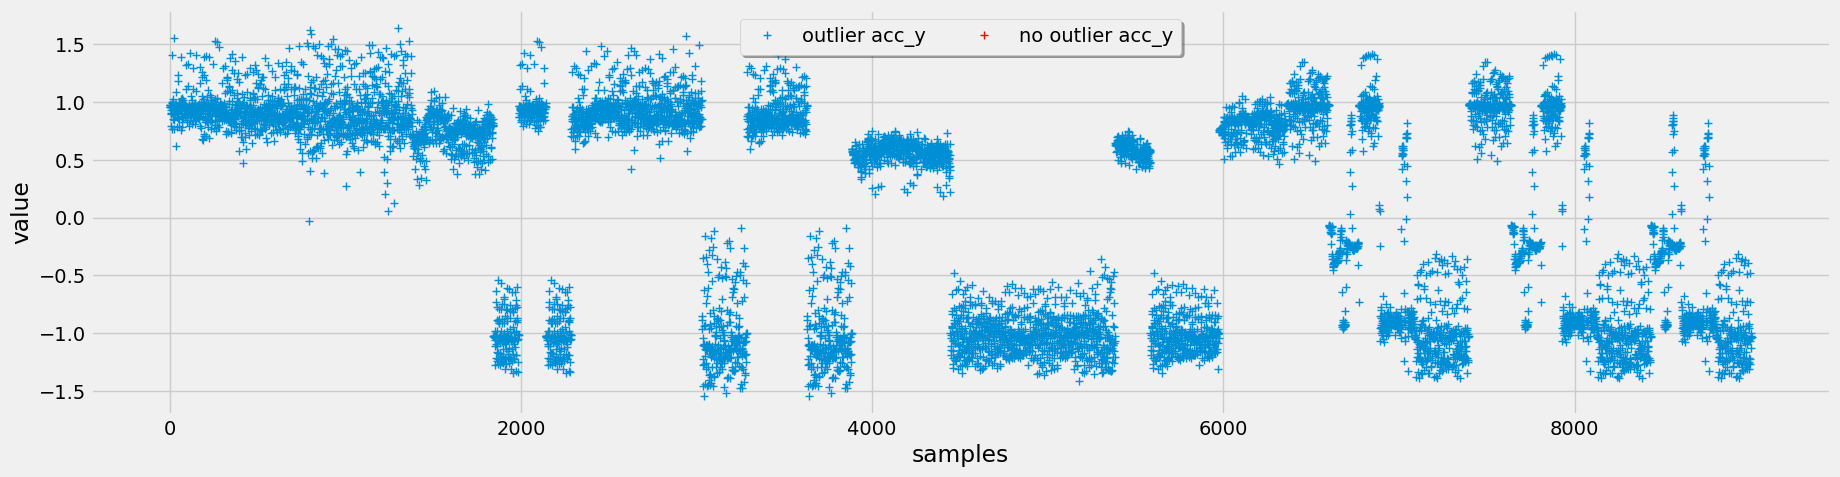

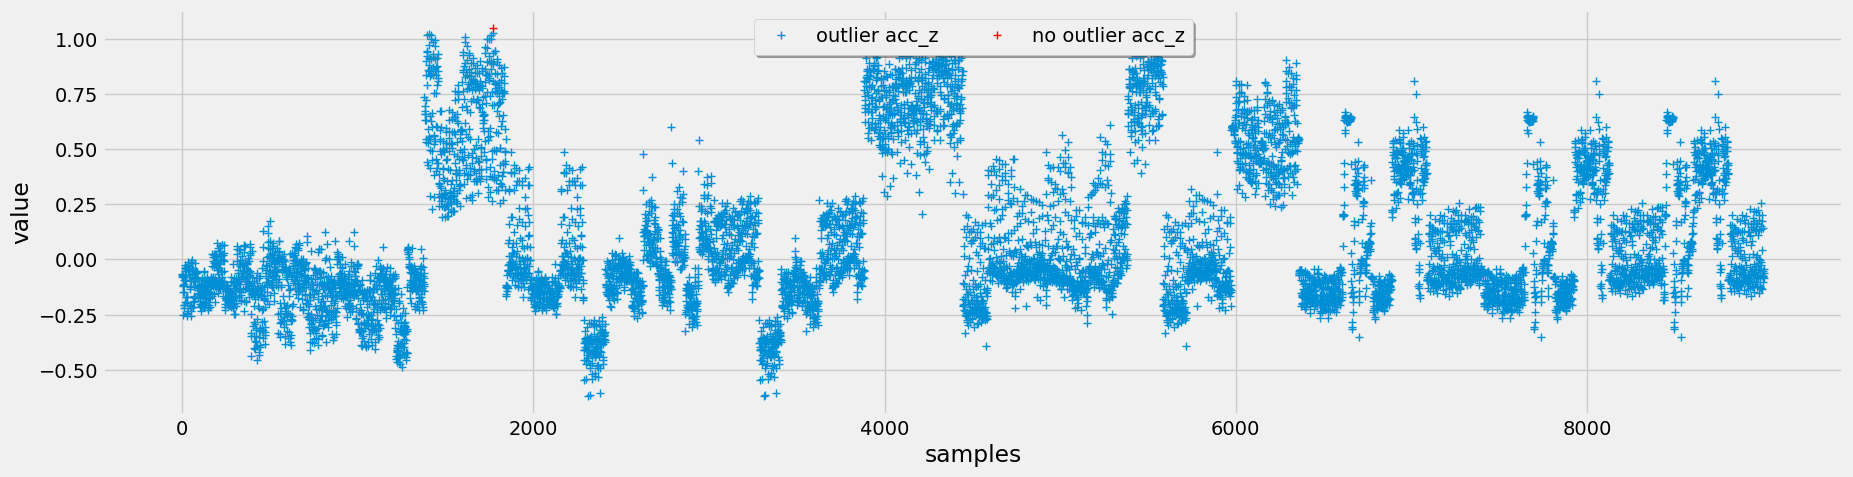

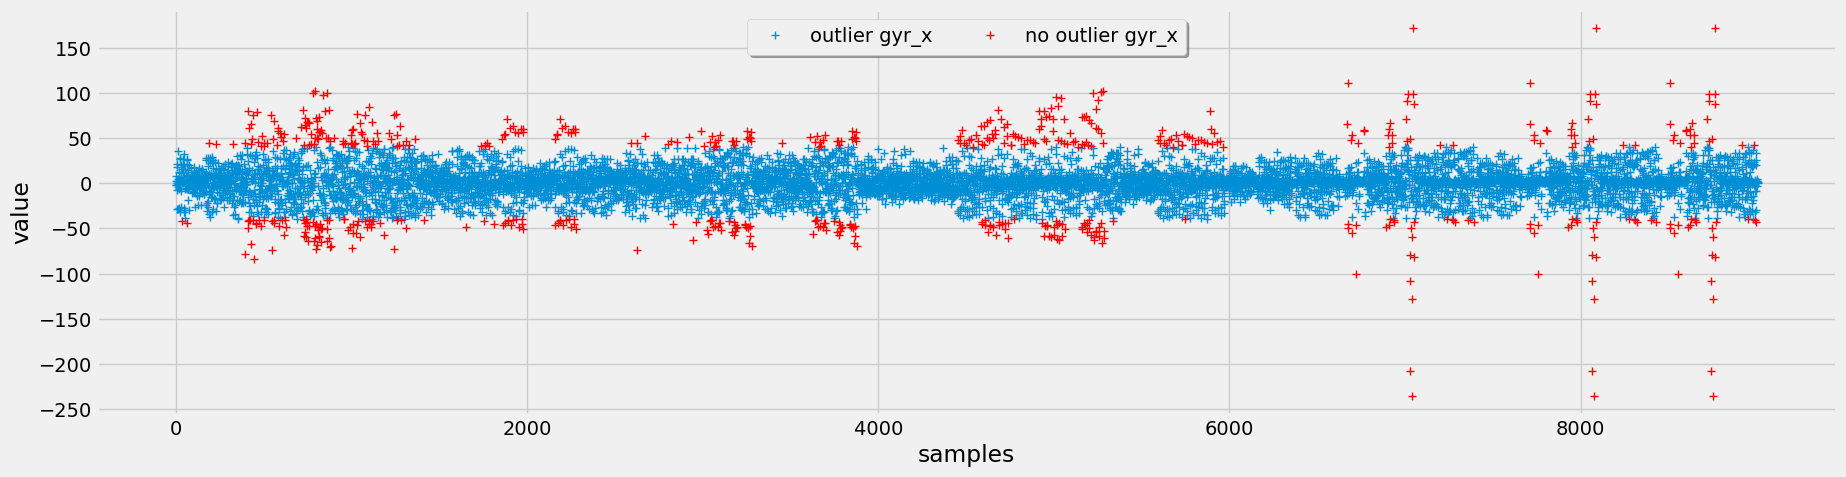

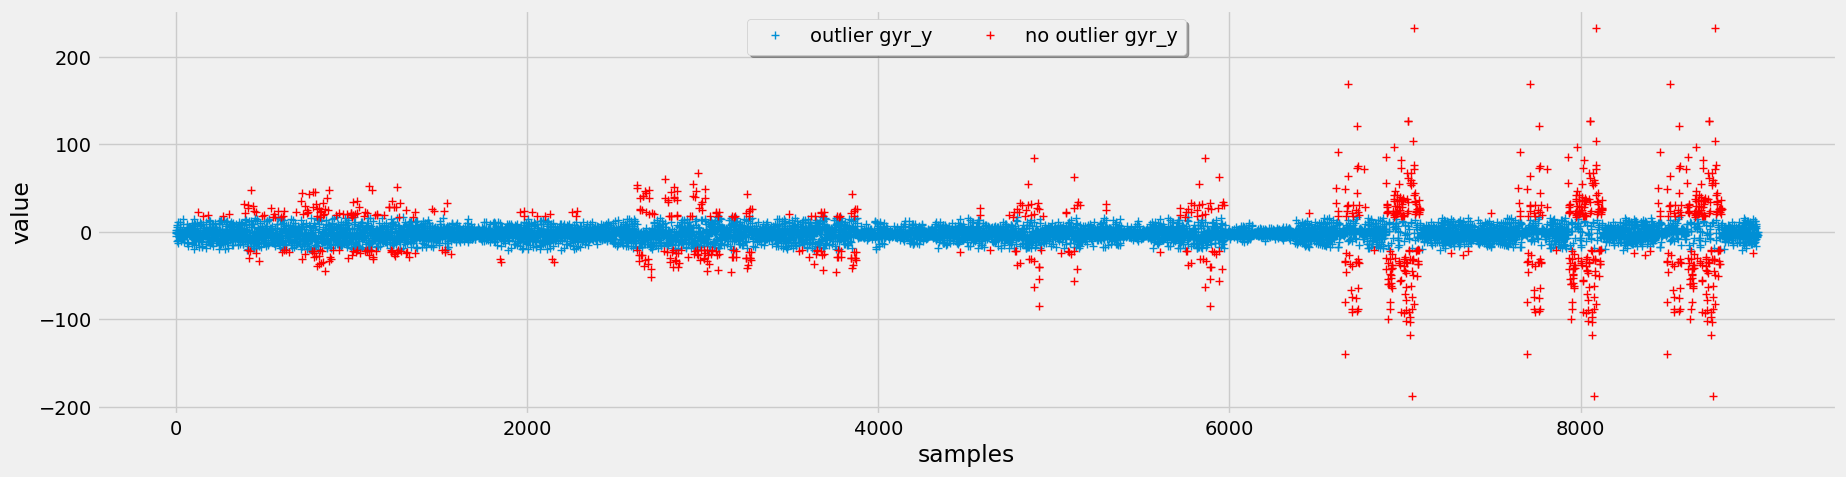

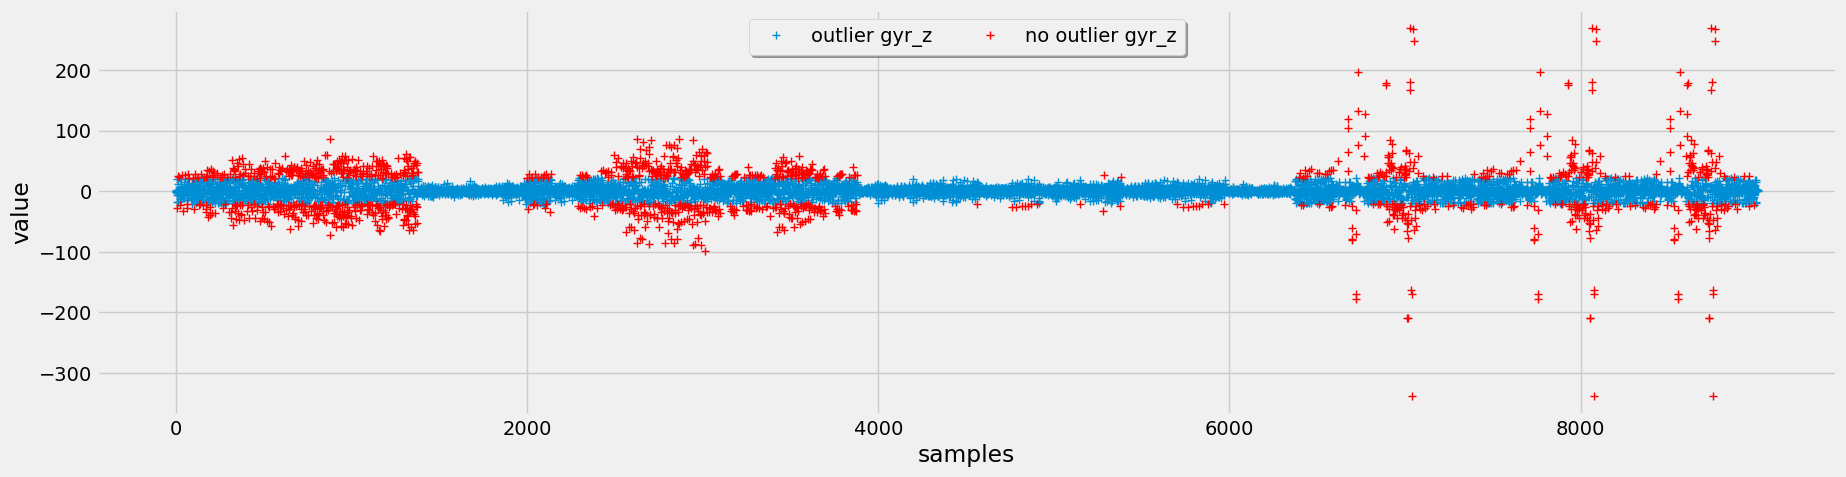

In [20]:
# Plot a single column
col = "acc_x"
dataset = remove_outliers.mark_outliers_iqr(df, col)
vis.plot_binary_outliers(
    dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
)

# Loop over all columns
for col in outlier_columns:
    dataset = remove_outliers.mark_outliers_iqr(df, col)
    vis.plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

As seen above, using the IQR method still shows too many outliers and many of these flagged data points may be legit. Another method should be attempted before making a final decision on handling outliers.

#### 2.3.3 - Chauvenet's Criterion for Outlier Detection

Chauvenet's criterion is a method for detecting outliers based on the idea that for normally distributed data, the probability of an outlier is relatively low. This won't work if the data isn't normally distributed, however. 

This method rejects an outlier from a dataset of size `N` when the probability of such observation is less than `1 / (C * N)` where `C` is usually 2.

Source: Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.

Source code of Chauvenet's function can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

Defined this function in the `remove_outliers` script as  `mark_outliers_chauvenet()`

array([[<Axes: title={'center': 'bench'}>,
        <Axes: title={'center': 'dead'}>,
        <Axes: title={'center': 'ohp'}>],
       [<Axes: title={'center': 'rest'}>,
        <Axes: title={'center': 'row'}>,
        <Axes: title={'center': 'squat'}>],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

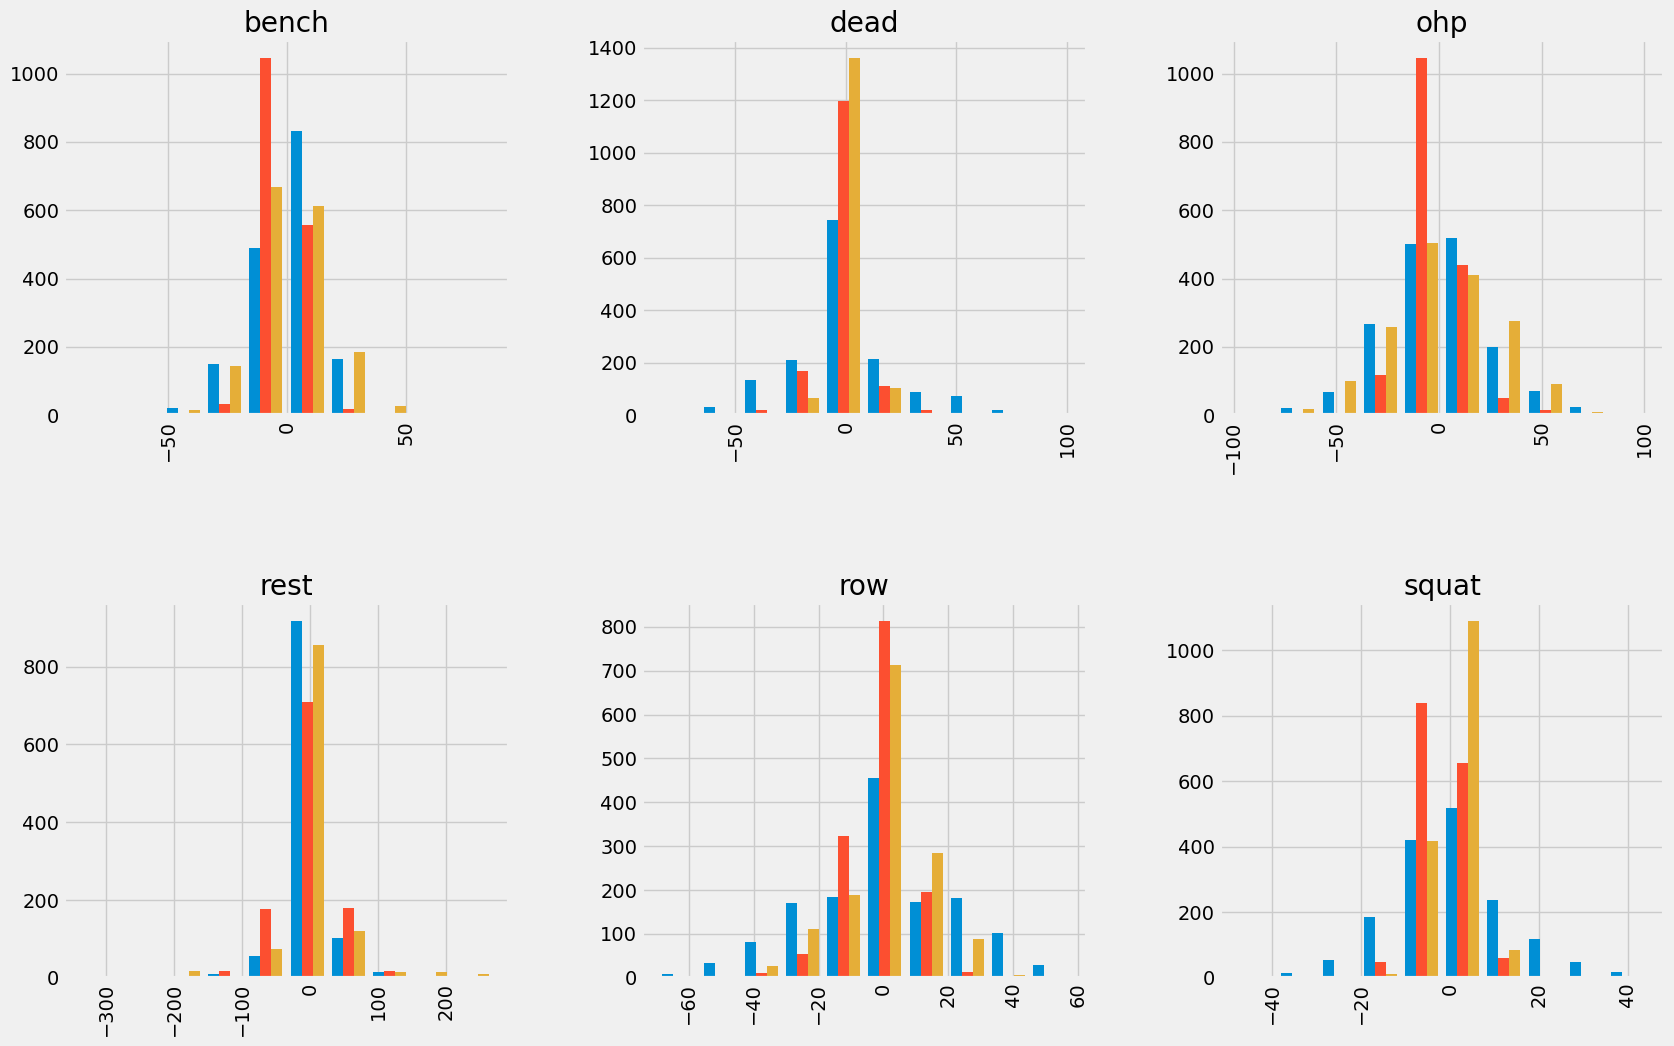

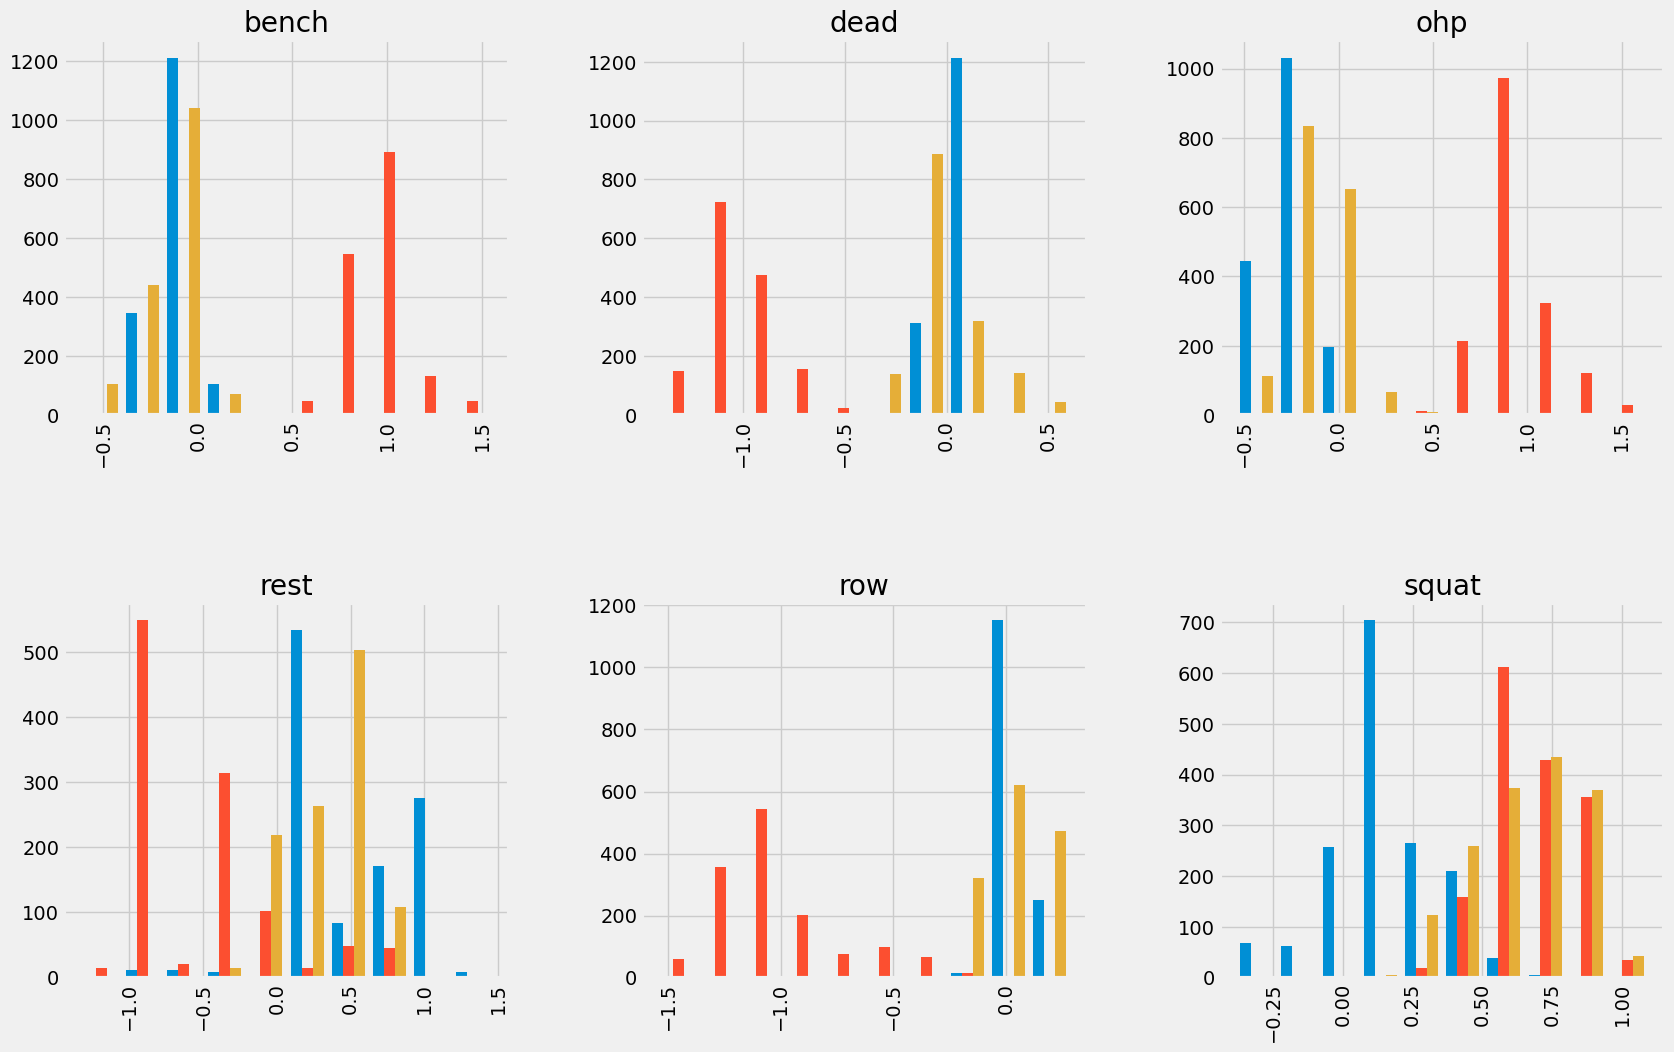

In [21]:
# First, check that the data is normally distributed
df[outlier_columns[3:] + ["label"]].hist(by="label", figsize=(20, 20), layout=(3, 3))
df[outlier_columns[:3] + ["label"]].hist(by="label", figsize=(20, 20), layout=(3, 3))

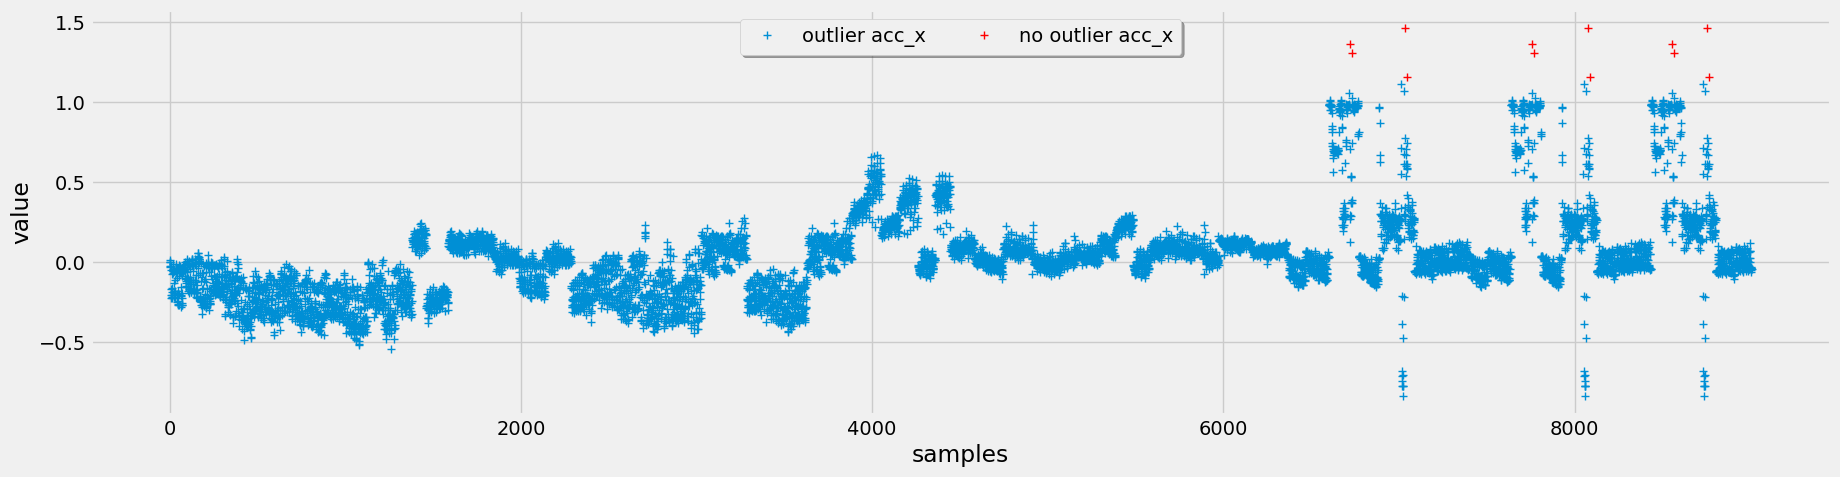

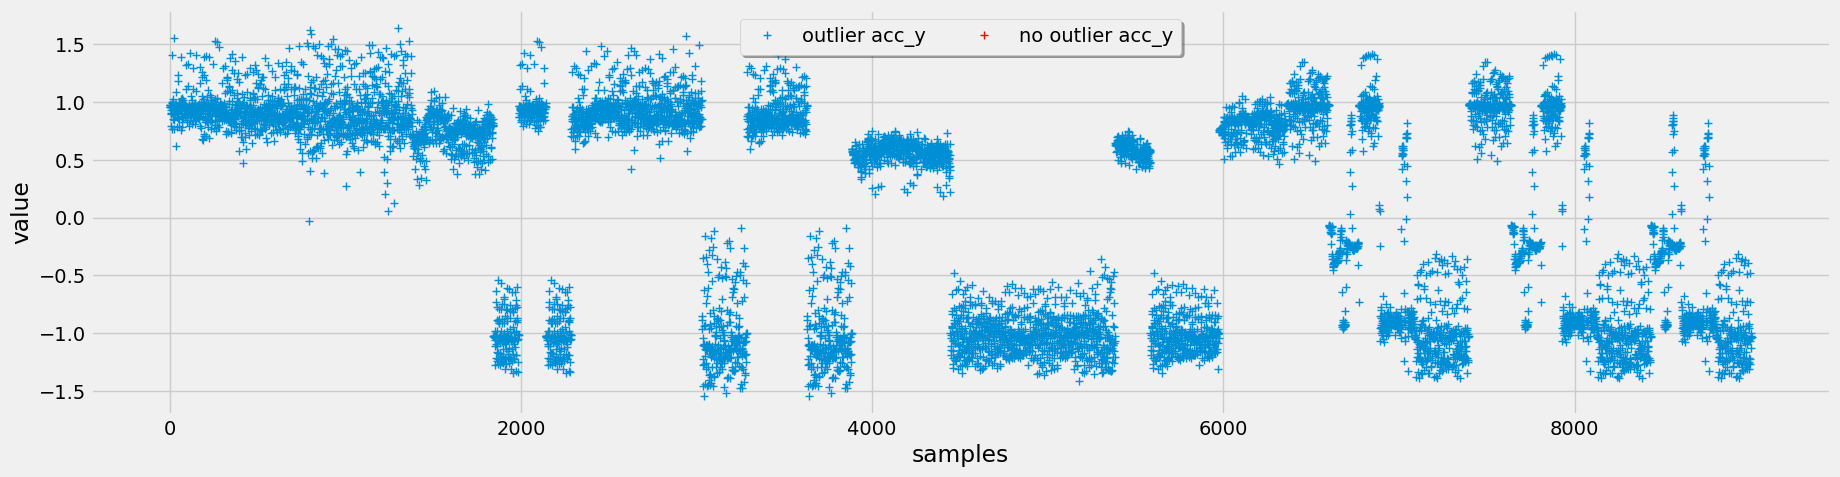

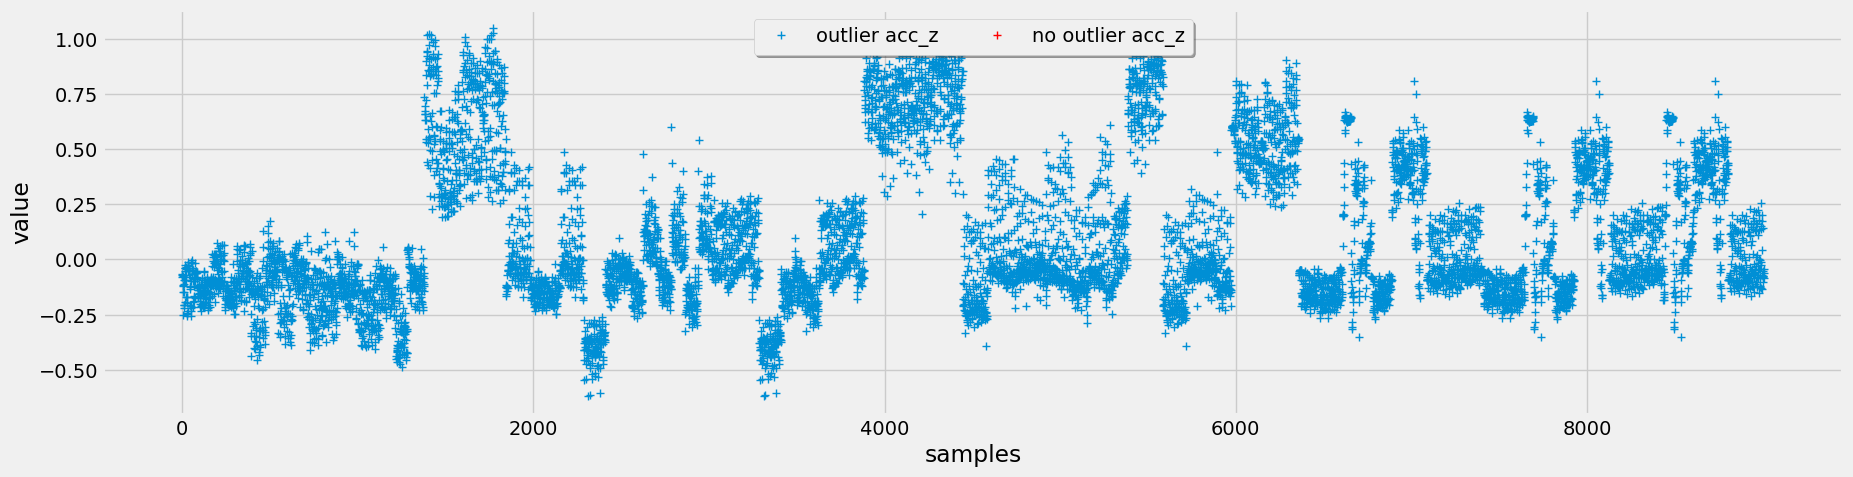

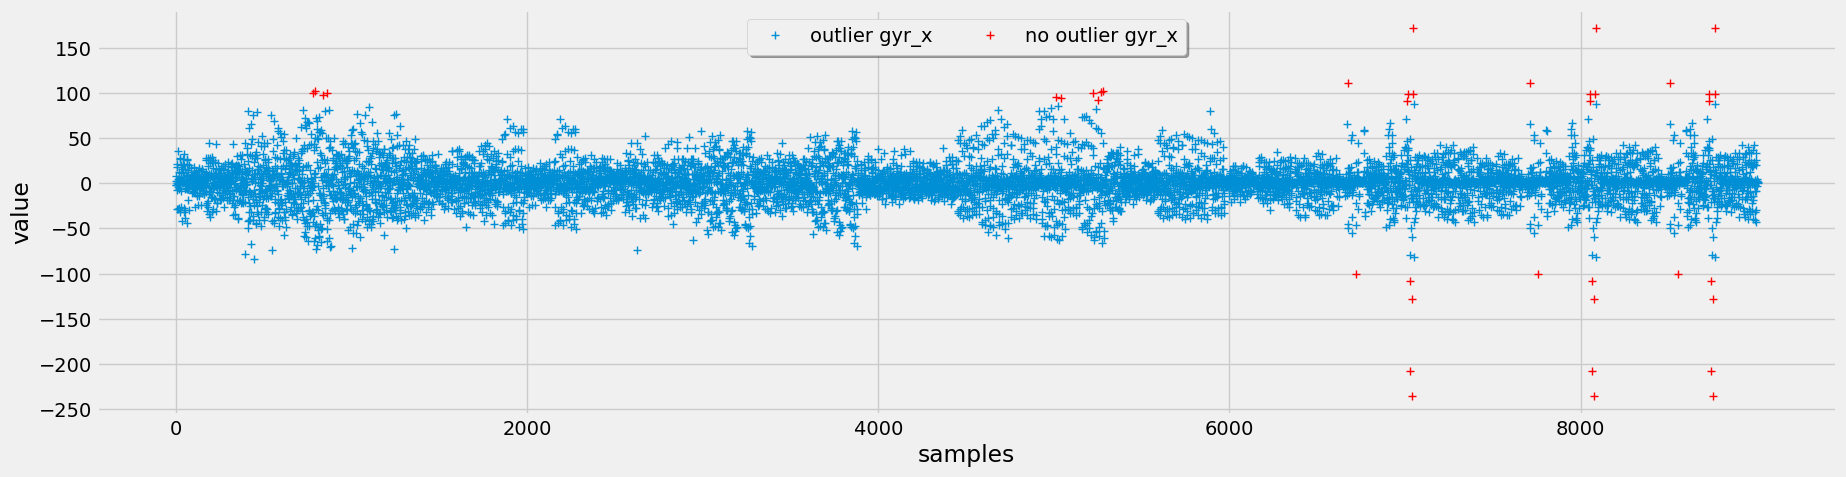

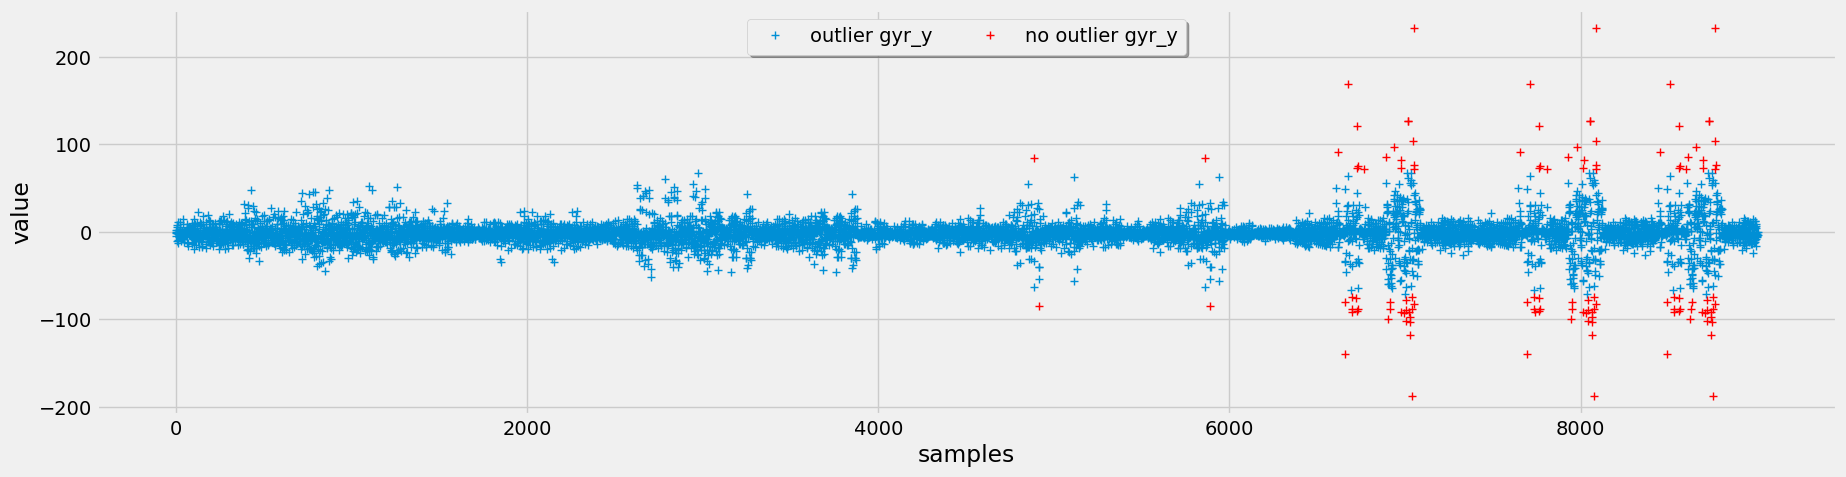

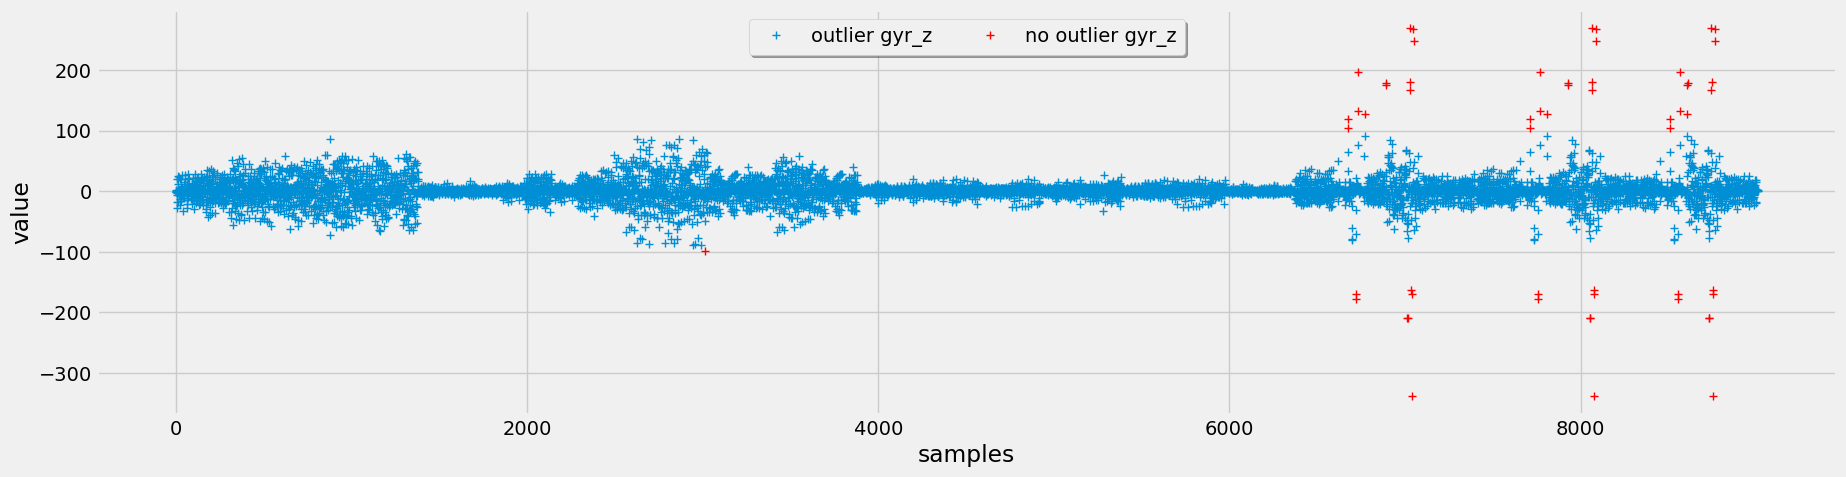

In [22]:
# Test the Chauvenet criterion on all columns
for col in outlier_columns:
    dataset = remove_outliers.mark_outliers_chauvenet(df, col)
    vis.plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

Using Chauvenet's method results in less outliers, which likely means they are true outliers.

#### 2.3.4 - Local Outlier Factor (LOF)

LOF is an unsupervised outlier detection method that assigns an anomaly score to each observation. The anomaly score is based on the distance of a sample with respect to its neighbors. 

Defined this function in the `remove_outliers` script as `mark_outliers_lof()`

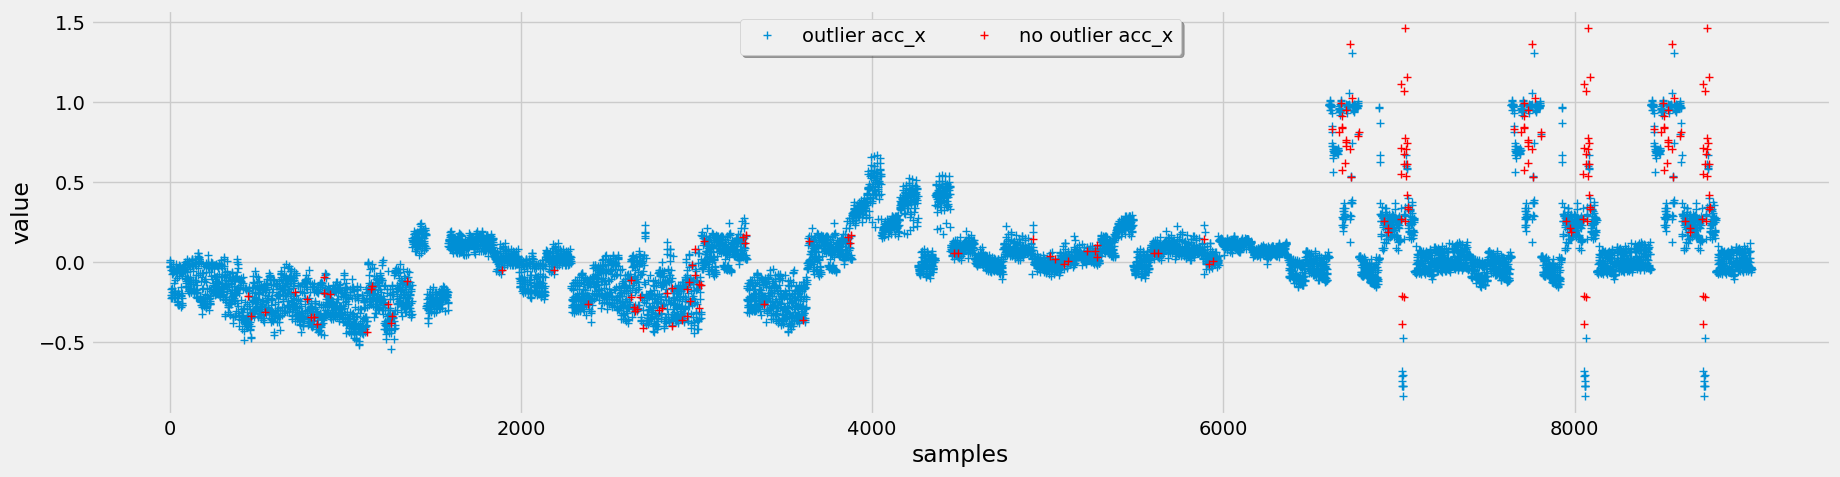

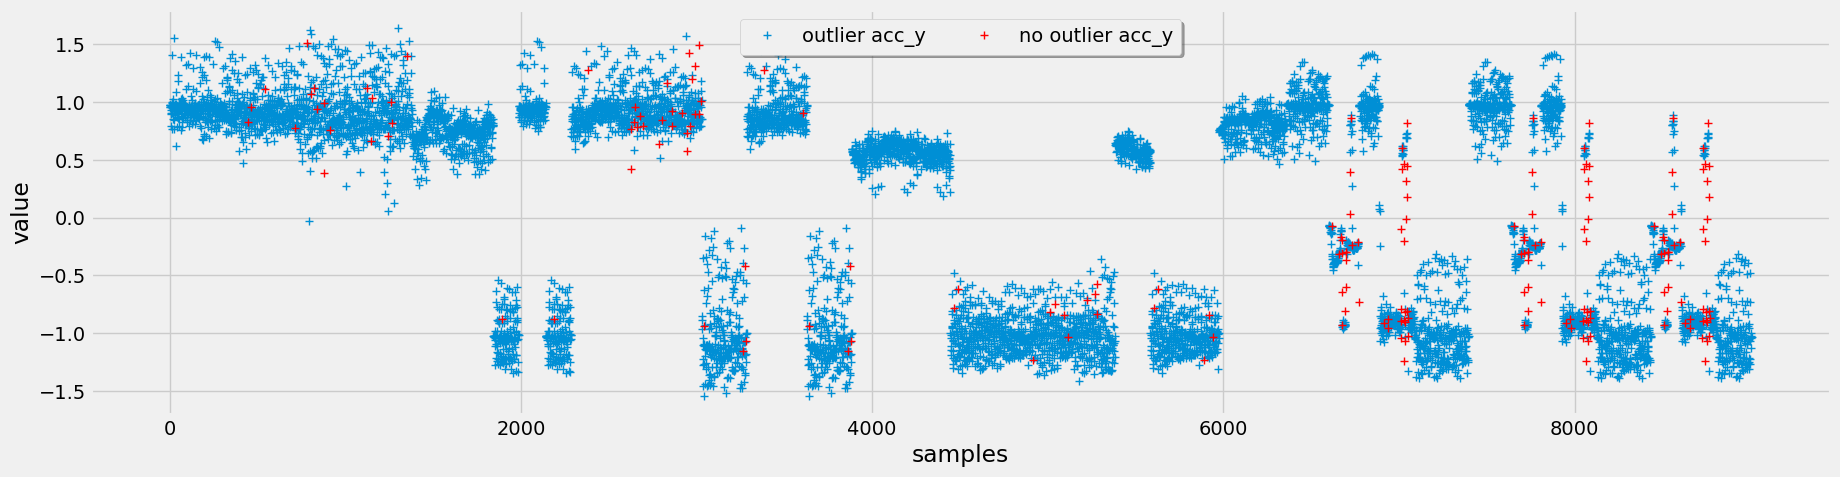

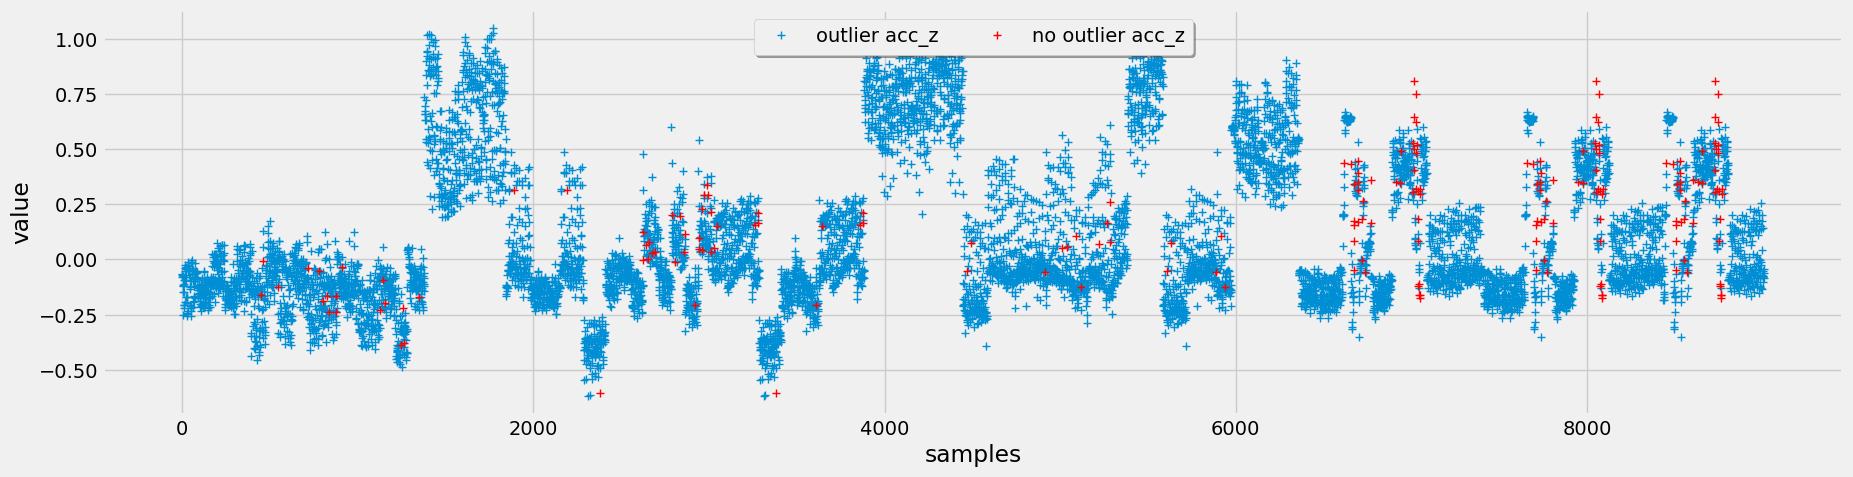

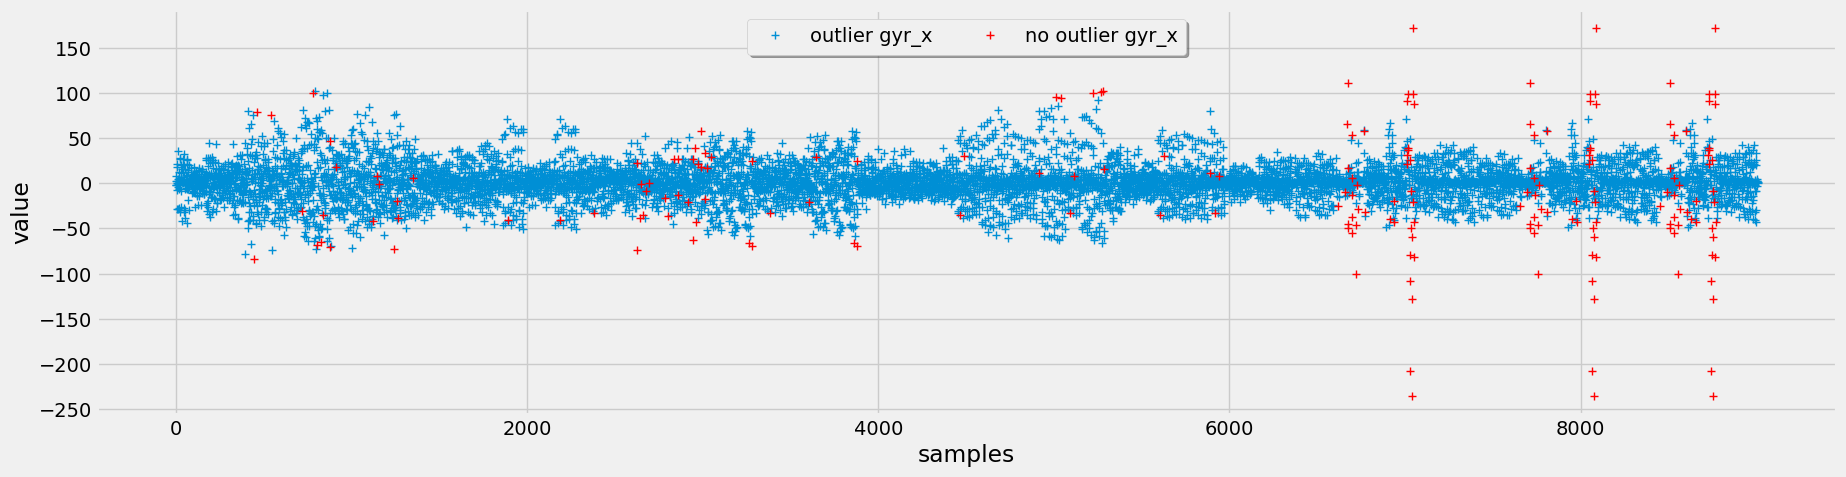

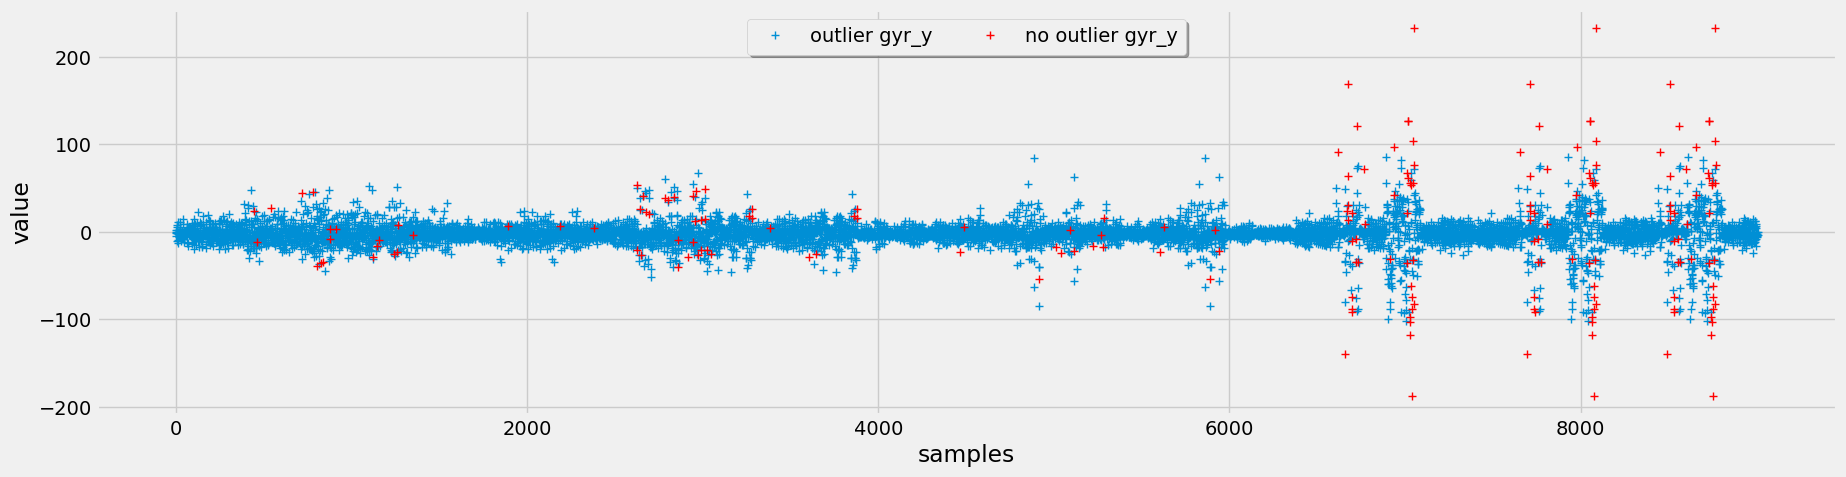

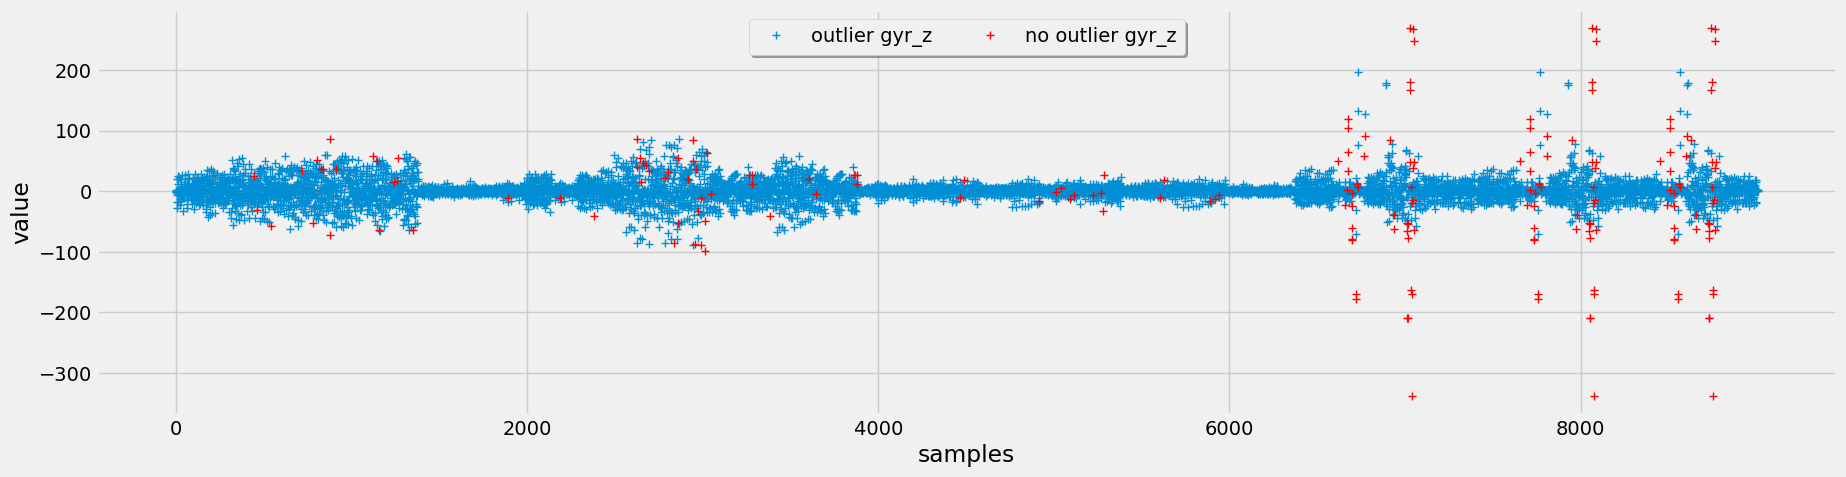

In [23]:
# Test the LOF method on all columns
dataset, outliers, X_scores = remove_outliers.mark_outliers_lof(df, outlier_columns)
for col in outlier_columns:
    vis.plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

The LOF method found outliers that seem within normal ranges but are identified as isolated data points due to distance from other clusters. 

### 2.4 - Check for Outliers Grouped by Excercise Type

Visually inspect outliers of each type of exercise and compare methods.

**Warning: This will output a lot of graphs. I commented out all methods but one to save graphing space.**

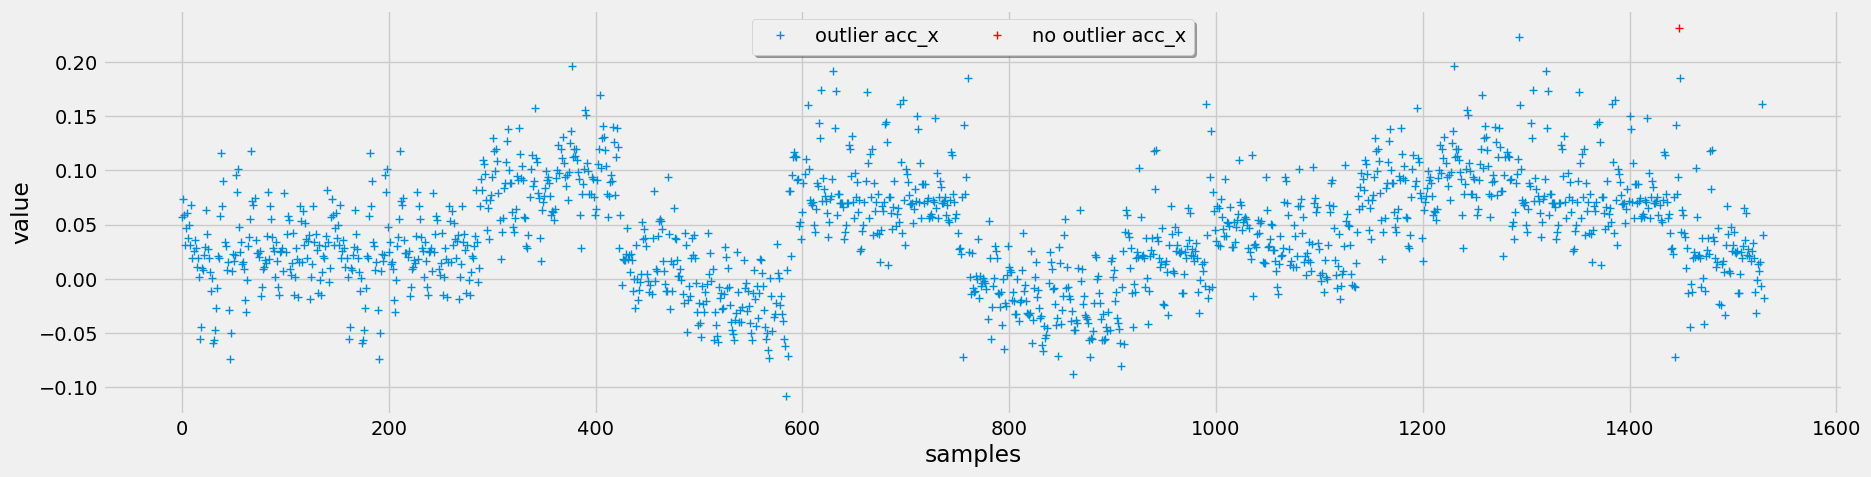

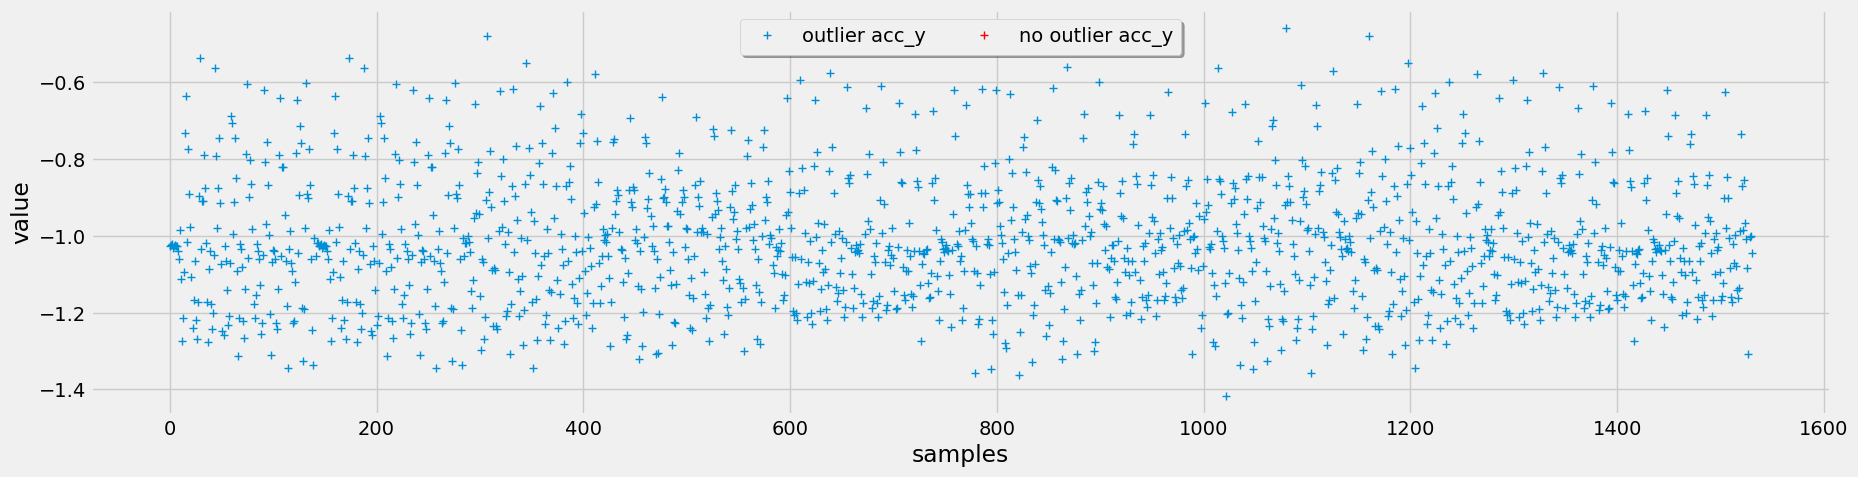

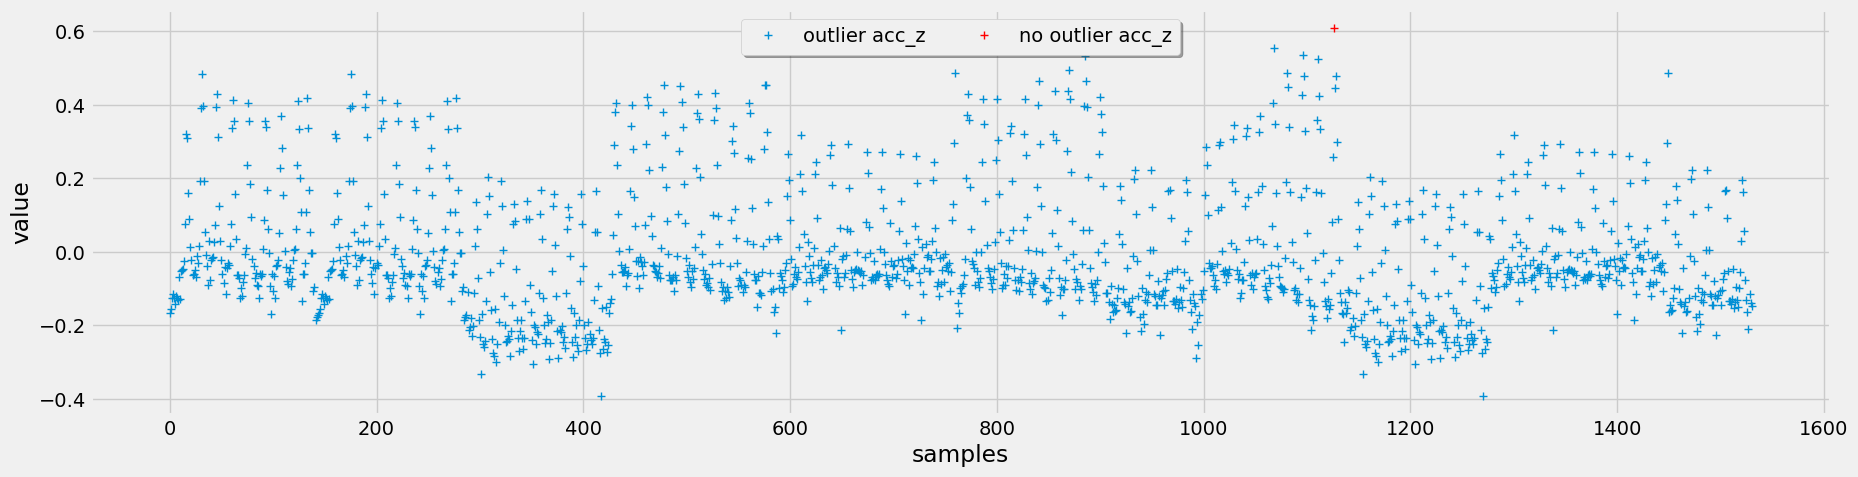

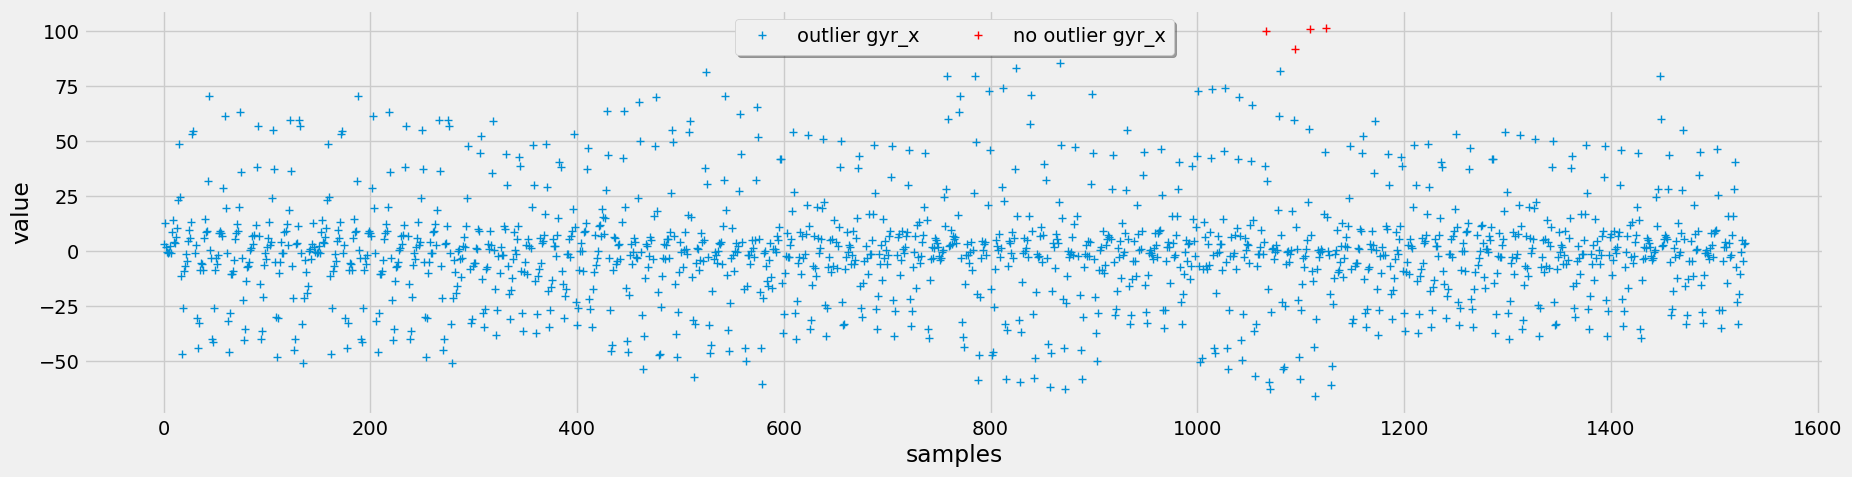

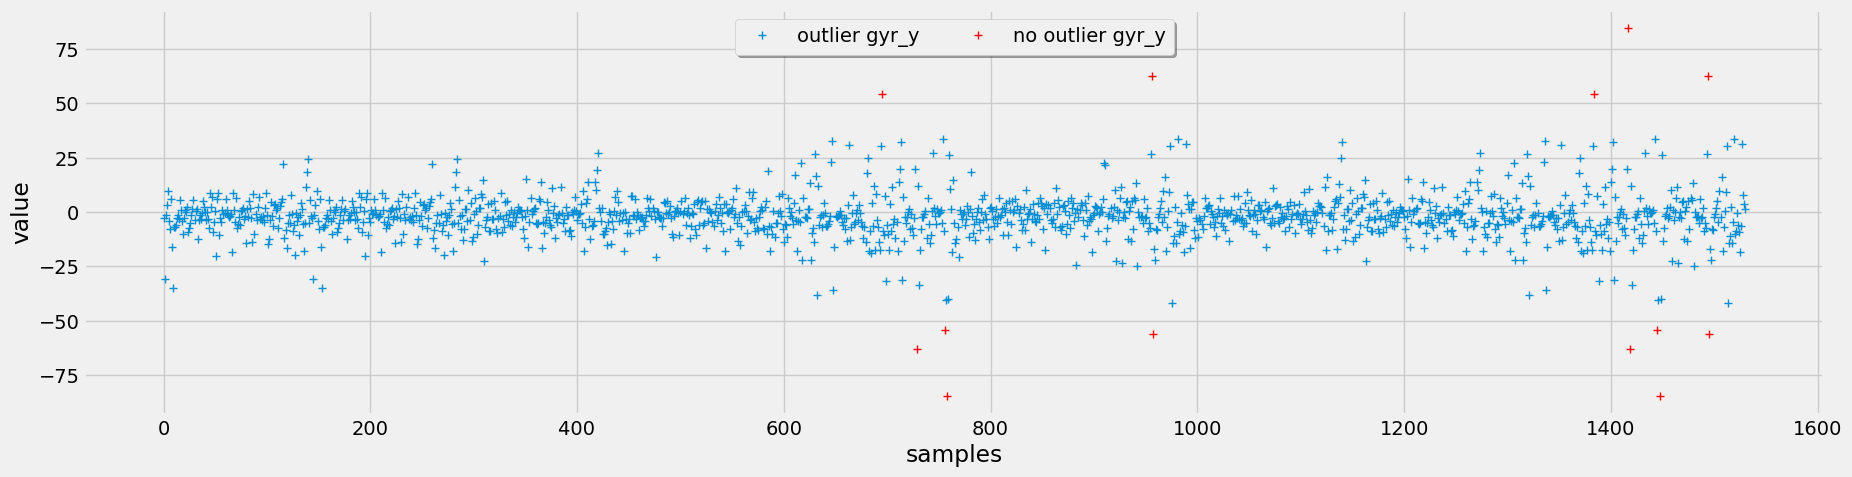

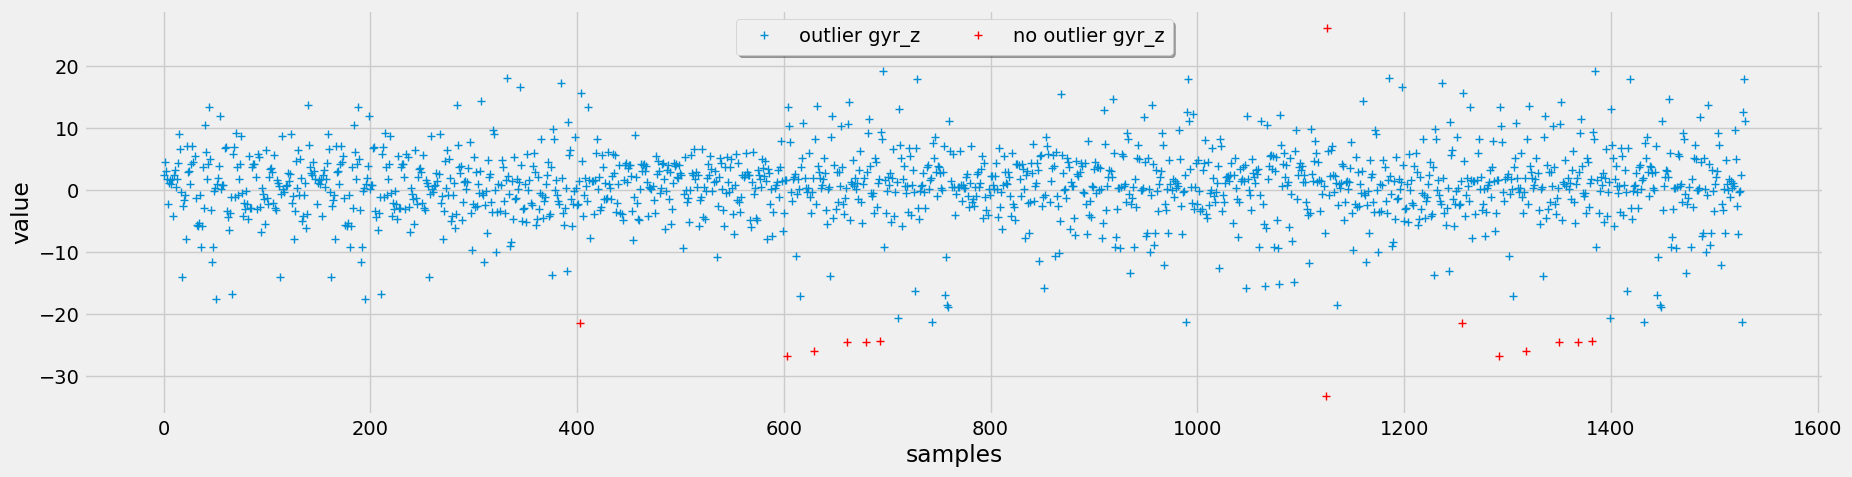

In [24]:
label = "dead"  # change this to visually inspect outliers for other labels

# # IQR method
# for col in outlier_columns:
#     dataset = remove_outliers.mark_outliers_iqr(df[df["label"] == label], col)
#     remove_outliers.plot_binary_outliers(dataset, col, col + "_outlier", reset_index=True)

# Chauvenet method
for col in outlier_columns:
    dataset = remove_outliers.mark_outliers_chauvenet(df[df["label"] == label], col)
    vis.plot_binary_outliers(dataset, col, col + "_outlier", reset_index=True)

# # LOF method
# dataset, outliers, X_scores = remove_outliers.mark_outliers_lof(
#     df[df["label"] == label], outlier_columns
# )
# for col in outlier_columns:
#     remove_outliers.plot_binary_outliers(dataset, col, "outlier_lof", reset_index=True)

### 2.5 - Choose the Best Outlier Removal Method

In this case, it appears that the Chauvenet method is the best one for removing outliers of the accelerometer and gyroscope sensor data.

Removed outliers will be replaced with NaN values. These will either be removed or imputed later.

In [25]:
# Test on single column: set outliers to NaN and later remove or impute them
col = "gyr_z"
dataset = remove_outliers.mark_outliers_chauvenet(df, col=col)
dataset[dataset["gyr_z_outlier"]]
dataset.loc[dataset["gyr_z_outlier"], "gyr_z"] = np.nan
dataset["gyr_z_outlier"].value_counts()

gyr_z_outlier
False    8951
True       58
Name: count, dtype: int64

Testing outlier removal appears to have worked without penalizing too many data points. Proceed with outlier removal using the Chauvenet's method on the entire database:

In [26]:
outliers_removed_df = remove_outliers.remove_outliers_nan(df, outlier_columns)

Removed 0 from acc_x for bench
Removed 2 from acc_x for ohp
Removed 0 from acc_x for squat
Removed 2 from acc_x for dead
Removed 0 from acc_x for row
Removed 0 from acc_x for rest
Removed 5 from acc_y for bench
Removed 6 from acc_y for ohp
Removed 0 from acc_y for squat
Removed 0 from acc_y for dead
Removed 0 from acc_y for row
Removed 0 from acc_y for rest
Removed 3 from acc_z for bench
Removed 6 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 1 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 2 from gyr_x for bench
Removed 4 from gyr_x for ohp
Removed 1 from gyr_x for squat
Removed 6 from gyr_x for dead
Removed 0 from gyr_x for row
Removed 12 from gyr_x for rest
Removed 14 from gyr_y for bench
Removed 15 from gyr_y for ohp
Removed 9 from gyr_y for squat
Removed 14 from gyr_y for dead
Removed 10 from gyr_y for row
Removed 9 from gyr_y for rest
Removed 13 from gyr_z for bench
Removed 1 from gyr_z for ohp
Removed 12 from gyr_z for squat
Re

Examine the dataset:

In [27]:
outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


Note the non-null counts are now less than 9009 for all sensors. These missing records is the result of outlier removal and thus has NaN values, which we may either impute or drop from the dataset entirely.

Save the dataset with removed outliers:

In [28]:
outliers_removed_df.to_pickle(
    "data/interim/02_data_outliers_removed_chauvenets.pkl"
)

## To be continued...

**To continue with feature engineering, continue with Part 3 of this notebook here:**

`/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb`

Github link: https://github.com/nkeblawi/nk-fitness-tracker/blob/main/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb